In [100]:
import numpy as np
import sklearn.datasets
import time
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm


In [82]:
def V_1(X):
    n = X.shape[0]

    X = np.sort(X)
    s = np.std(X)

    tmp_1 = True
    tmp_2 = True

    V_array = np.array([])


    for m in range(1, int(n/2)):

        product = 1


        for i in range(1, n + 1):

            if i - m <= 1:
                X_1 = X[0]
                tmp_1 = False

            if i + m >= n:
                X_2 = X[-1]
                tmp_2 = False


            if tmp_1:
                X_1 = X[i - m - 1]

            if tmp_2:
                X_2 = X[i + m - 1]

            tmp_1 = True
            tmp_2 = True
                
            product *= 1 / (X_2 - X_1)


        V = (2 * np.pi * np.e * s**2)**(n / 2) * 2 * m / n * product 

        V_array = np.append(V_array, V)


    return V_array

In [78]:
alpha = 0.1
n = 10 #sample size
N = 100 #number of samples for monte carlo

X = np.random.normal(0, 1, size=(N, n))


In [102]:
C_array = np.array([])

alpha = 0.1
N = 100 #number of samples for monte carlo
alpha = 0.1
n_array = np.linspace(10, 100, 10, dtype=int) # sample size

for n in tqdm(n_array):

    V_array = np.array([])

    X = np.random.normal(0, 1, size=(N, n))

    for i in tqdm(range(N)):

        V = np.min(np.log(V_1(X[i])))
        V_array = np.append(V_array, V)


    V_array = np.sort(V_array)

    C = V_array[int(alpha * N) - 2]

    C_array = np.append(C_array, C)



100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


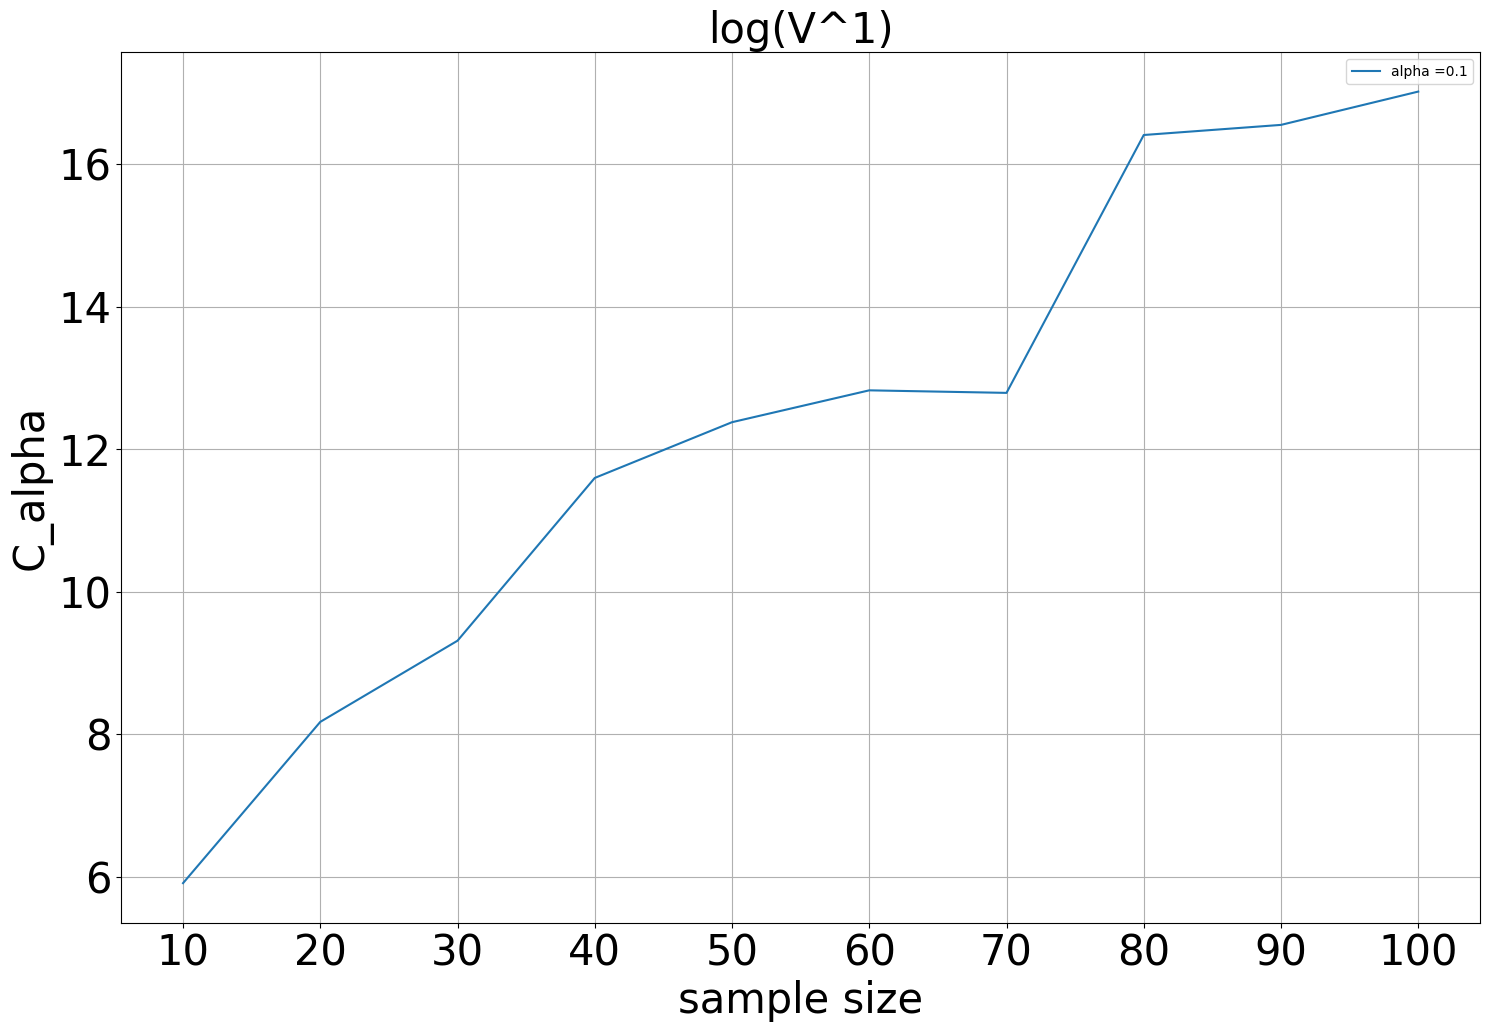

In [103]:
f,ax1 = plt.subplots(1,figsize = (15,10))



plt.plot(np.linspace(10, 100, 10, dtype=int), C_array, label='alpha ='+str(alpha))


ax1.grid(alpha = 1)
ax1.xaxis.set_major_locator(MaxNLocator(integer=False))
ax1.set_xlabel('sample size', fontsize = 30 )
ax1.set_ylabel('C_alpha', fontsize = 30 )


ax1.legend(fontsize = 10)


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.tight_layout()

plt.title('log(V^1)', fontsize = 30)
plt.show()
